# Wiener Filter:

The Wiener filter is a common algorithm to suppress the noise and a good example for working with the spectrogram.

In [15]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import os
os.chdir('../Python')
import TrainingsDataInterface
import Constants
import RTISI
import WaveInterface

TempFolder = "NeuralNetworks/DenoisingData"
FilenameData = TempFolder + '/Data.npz'
try:
    os.mkdir(TempFolder)
except:
    pass

r = Constants.theConstants.getSamplingFrequencyMicrofone()
TimeMemoryOfInput = 5

## Logarithmic frequency scaling
The following algorithms transform the linear frequency axis from the FFT into a logarithmic frequency axis.

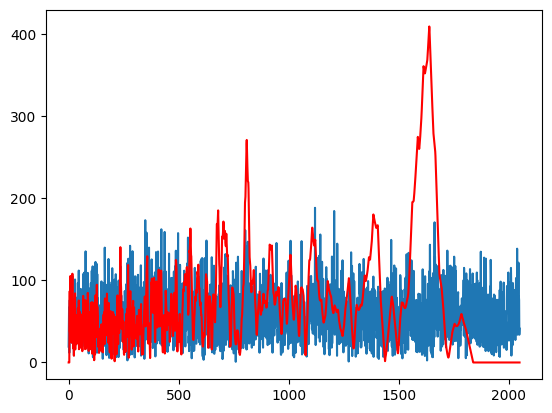

In [16]:
def Bark2KiloHertz(b):
    return 1.96 * (b + 0.53) / (26.28 - b)

def MelFilterBank(NumberOfCenterFrequenciesPerBark, NumberOfInputFrequencyBins, SamplingRate):
    FFTLen = 2 * NumberOfInputFrequencyBins - 2
    Deltaf = SamplingRate / FFTLen
    f = np.arange(NumberOfInputFrequencyBins) * Deltaf
    CutoffFrequenciesInBark = np.arange(24*NumberOfCenterFrequenciesPerBark+1) / NumberOfCenterFrequenciesPerBark
    CutoffFrequenciesInHertz = Bark2KiloHertz(CutoffFrequenciesInBark) * 1000
    CenterFrequenciesInHertz = np.diff(CutoffFrequenciesInHertz) / 2
    CenterFrequenciesInHertz += CutoffFrequenciesInHertz[0:CutoffFrequenciesInHertz.shape[0]-1]
    T_Hertz2Bark = np.zeros((CenterFrequenciesInHertz.shape[0], NumberOfInputFrequencyBins))
    for b in range(T_Hertz2Bark.shape[0]):
        m1 = (1 - 1/np.sqrt(2)) / (CenterFrequenciesInHertz[b] - CutoffFrequenciesInHertz[b]) # first derivative of first line
        m2 = (1 - 1/np.sqrt(2)) / (CenterFrequenciesInHertz[b] - CutoffFrequenciesInHertz[b+1]) # first derivative of second line
        assert m1 > 0, 'm1 must be greater 0'
        assert m2 < 0, 'm2 must be smaller 0'
        b1 = 1 - m1 * CenterFrequenciesInHertz[b] # offset of first line
        b2 = 1 - m2 * CenterFrequenciesInHertz[b] # offset of second line
        assert b1 < 1/np.sqrt(2), 'b1 must be smaller than 1/sqrt(2)'
        assert b2 > 0, 'b2 must be greater 0'
        v1 = m1 * f + b1
        v2 = m2 * f + b2
        v3 = np.minimum(v1, v2)
        v4 = np.maximum(v3, 0.0)
        #f1 = -b1 / m1 # zero crossing of the first line
        #f2 = -b2 / m2 # zero crossing of the second line
        T_Hertz2Bark[b, :] = v4 * 1.5 / (CenterFrequenciesInHertz[b]**0.1) #/ (0.5*(f2 - f1))
    assert np.amin(T_Hertz2Bark) >= 0.0, 'T_Hertz2Bark must be greater or equal zero'
    return T_Hertz2Bark, CenterFrequenciesInHertz

class CTransformSpectralEnvelope(object):
    
    def __init__(self):
        self.__NumberOfBandsPerBark = -1.0
        self.__XShape0 = 0
    
    def __EvaluateTransformMatrix(self, SamplingRate):
        #self.__T = np.eye(self.__XShape0)
        #self.__Tinverse = self.__T
        self.__T, CenterFrequenciesInHertz = MelFilterBank(NumberOfCenterFrequenciesPerBark = self.__NumberOfBandsPerBark, NumberOfInputFrequencyBins = self.__XShape0, SamplingRate = SamplingRate)
        #self.__Tinverse = np.linalg.pinv(self.__T)
        #self.__Tinverse = np.transpose(self.__T)
        assert np.amin(self.__T) >= 0.0, 'self.__T must be greater or equal zero'
    
    def TransformSpectralEnvelope(self, X, SamplingRate, NumberOfBandsPerBark):
        assert NumberOfBandsPerBark > 0, 'only positive number of bands per Bark are reasonable'
        SomethingChanged = np.abs(NumberOfBandsPerBark - self.__NumberOfBandsPerBark) > 1e-3
        SomethingChanged = SomethingChanged or (np.abs(self.__XShape0 - X.shape[0]) > 1e-3)
        if SomethingChanged:
            self.__NumberOfBandsPerBark = NumberOfBandsPerBark
            self.__XShape0 = X.shape[0]
            self.__EvaluateTransformMatrix(SamplingRate)
        return np.matmul(self.__T, X)  

    def InverseTransformSpectralEnvelope(self, X):
        return np.matmul(np.transpose(self.__T), X)

x = np.random.randn(2**12)
X = np.fft.rfft(x)
ATransformSpectralEnvelope = CTransformSpectralEnvelope()
Y = ATransformSpectralEnvelope.TransformSpectralEnvelope(X, r, NumberOfBandsPerBark = 27)
Z = ATransformSpectralEnvelope.InverseTransformSpectralEnvelope(Y)

import matplotlib.pyplot as plt

plt.plot(np.abs(X))
plt.plot(np.abs(Z), 'r')
plt.show()


## Logarithmic magnitude scaling
The logarithmic magnitude scaling and the inverse operation is performed by a compander-class:

In [17]:
class CCompander(object):

    def __init__(self):
        self.__ScalingFactor = 1000
        self.__InputMinimum = 0.0
        self.__InputMaximum = 1.0
        self.__SelfTest()

    def __SelfTest(self):
        x = np.random.rand(10000) * (self.__InputMaximum - self.__InputMinimum) + self.__InputMinimum
        y = self.Compressor(x)
        z = self.Expander(y)
        SNR = 10*np.log10(np.sum(x**2) / np.sum((x-z)**2+1e-16))
        assert SNR > 100, 'mismatch between compressor and expander'

    def Compressor(self, x):
        assert np.amin(x) >= self.__InputMinimum, 'minimum condition violated'
        assert np.amax(x) <= self.__InputMaximum, 'maximum condition violated'
        return np.log(self.__ScalingFactor * x + 1) / np.log(self.__ScalingFactor + 1)

    def Expander(self, x):
        return (np.exp(np.log(self.__ScalingFactor + 1) * x) - 1) / self.__ScalingFactor
        #return (self.__ScalingFactor + np.exp(x)) / self.__ScalingFactor

ACompander = CCompander()

## Evaluate log-mel-spectrogram
In speech processing algorithms, analysis is usually applied on the double logarithmic scaling of the spectrogram: The frequency axis is scaled to the logarithmical mel-scale and the magnitudes are also scaled logarithmically.

In [18]:
ATransformSpectralEnvelope = CTransformSpectralEnvelope()

NumberOfBandsPerBark = 27.0
HopSizeInMilliseconds = 10
OverlappingInPercent = 75
hs = int(r * HopSizeInMilliseconds / 1000)
ws = int(hs / (1 - OverlappingInPercent/100))
w = 0.5 - 0.5 * np.cos(2*np.pi*(np.arange(ws)+0.5)/ws)

def EvalLogMelSpectrogram(x, Fs):    
    FFTLen = int(2**np.ceil(np.log2(ws)))
    NumberOfBlocks = int((x.shape[0] - ws) / hs) + 1
    X = None
    for BlockNumber in range(NumberOfBlocks):
        idx1 = BlockNumber * hs
        idx2 = idx1 + ws
        BlockAnalysis = x[idx1:idx2] * w
        SpectrumAnalysis = np.abs(np.fft.rfft(BlockAnalysis, n = FFTLen)) / FFTLen
    
        SmoothedEnvelopeSpectrum = ATransformSpectralEnvelope.TransformSpectralEnvelope(SpectrumAnalysis,
                                                                                        SamplingRate = Fs,
                                                                                        NumberOfBandsPerBark = NumberOfBandsPerBark)
        assert np.amin(SmoothedEnvelopeSpectrum) >= 0, 'SmoothedEnvelopeSpectrum must be greater or equal zero'
        if X is None:
            X = np.zeros((SmoothedEnvelopeSpectrum.shape[0], NumberOfBlocks))
        X[:, BlockNumber] = ACompander.Compressor(SmoothedEnvelopeSpectrum)
    return X

def LogMelSpectrum2LinearSpectrum(X):
    ExpanderSignal = ACompander.Expander(X)
    return ATransformSpectralEnvelope.InverseTransformSpectralEnvelope(ExpanderSignal)

def EvalTimeDomainSignal(X):
    ARTISI = RTISI.CRTISI(hs, w)
    x = np.zeros(((X.shape[1] - 1) * hs + ws))
    for BlockNumber in range(X.shape[1]):
        idx1 = BlockNumber * hs
        idx2 = idx1 + ws
        SpectrumSynthesis = LogMelSpectrum2LinearSpectrum(X[:, BlockNumber])
        BlockSynthesis = ARTISI.ProcessNewColumnOfSpectrogram(SpectrumSynthesis)
        x[idx1:idx2] += BlockSynthesis
    return x


## Noise Model
Again, AWGN is used as a noise model.

In [19]:
def ApplyNoise(x):
    return x + np.random.randn(x.shape[0]) * 0.1

## Collecting the data
In the following codeblock, the speech signals are transformed into trainings-, validation- and testdata. Input of the algorithm is the log-mel-spectrogram of the narrowband-signal of the last TimeMemoryOfInput columns. The outputdata or ground truth is the column of the wideband log-mel-spectrogram.

Warning: This Code is slow. It need to be called only if the trainingsdata need to be re-evaluated. Otherwise, everything is loaded in the next code block directly from the hard disk.

In [20]:
ATrainingsDataInterface = TrainingsDataInterface.CTrainingsDataInterface()

def GetAudioWithConstantLength(x, Fs):
    AudioDataLengthInMilliseconds = 500
    LengthInSamples = int(AudioDataLengthInMilliseconds * Fs / 1000)
    if x.shape[0] < LengthInSamples:
        y = np.concatenate((x, np.zeros((LengthInSamples - x.shape[0]))), axis = 0)
    else:
        E_cumsum = np.cumsum(x**2)
        tmp = E_cumsum[LengthInSamples:]
        tmp -= E_cumsum[:tmp.shape[0]]
        MaxIndex = np.argmax(tmp)
        y = x[MaxIndex:MaxIndex + LengthInSamples]
    assert np.abs(y.shape[0] - LengthInSamples) < 1e-1, 'wrong output length'
    return y

def EvaluateAllData():
    TrainingsCounter = 0
    Input = None
    for CommandIndex in tqdm(range(ATrainingsDataInterface.GetNumberOfCommands())):
        MaxInstanceIndex = ATrainingsDataInterface.GetNumberOfCommandInstances(CommandIndex)
        if MaxInstanceIndex > 10: MaxInstanceIndex = 10
        for InstanceIndex in range(MaxInstanceIndex):
            x, Fs, bits = ATrainingsDataInterface.GetWaveOfCommandInstance(CommandIndex, InstanceIndex)
            x = GetAudioWithConstantLength(x, Fs)
            y = ApplyNoise(x)
            
            X = EvalLogMelSpectrogram(x, Fs)
            Y = EvalLogMelSpectrogram(y, Fs)
            if not (X is None):            
                if Input is None:
                    Input = np.zeros((250000, X.shape[0], TimeMemoryOfInput))
                    Output = np.zeros((Input.shape[0], X.shape[0]))            
                
                idx1 = 0
                idx2 = Input.shape[2]
                while idx2 < X.shape[1]:
                    Input[TrainingsCounter, :, :] = Y[:, idx1:idx2]
                    Output[TrainingsCounter, :] = X[:, idx2]
                    idx1 += 1
                    idx2 += 1
                    TrainingsCounter += 1

    # partitioning in training, validation, test
    PercentageTraining = 0.8
    PercentageValidation = 0.1
    PercentageTest = 1.0 - PercentageTraining - PercentageValidation
    assert PercentageTest > 0.0, 'wrong partitioning between training, validation and test'
    LastIndexTraining = int(TrainingsCounter * PercentageTraining)
    LastIndexValidation = int(TrainingsCounter * (PercentageTraining + PercentageValidation))
    Input_Training = Input[:LastIndexTraining, ...]
    Output_Training = Output[:LastIndexTraining, ...]
    Input_Validation = Input[LastIndexTraining:LastIndexValidation, ...]
    Output_Validation = Output[LastIndexTraining:LastIndexValidation, ...]
    Input_Test = Input[LastIndexValidation:TrainingsCounter, ...]
    Output_Test = Output[LastIndexValidation:TrainingsCounter, ...]
    del Input
    del Output
    return Input_Training, Output_Training, Input_Validation, Output_Validation, Input_Test, Output_Test

Input_Training, Output_Training, Input_Validation, Output_Validation, Input_Test, Output_Test = EvaluateAllData()
np.savez(FilenameData, x0 = Input_Training, x1 = Output_Training, x2 = Input_Test, x3 = Output_Test, x4 = Input_Validation, x5 = Output_Validation)


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:50<00:00,  1.08s/it]


## Load the data
In the following code block the pre-evaluated trainings-, validation- and testdata is loaded.

In [21]:
def GetAllData():    
    try:
        data = np.load(FilenameData)
        Input_Training = data['x0']
        Output_Training = data['x1']
        Input_Test = data['x2']
        Output_Test = data['x3']
        Input_Validation = data['x4']
        Output_Validation = data['x5']
    except:
        Input_Training, Output_Training, Input_Validation, Output_Validation, Input_Test, Output_Test = EvaluateAllData()
        np.savez(FilenameData, x0 = Input_Training, x1 = Output_Training, x2 = Input_Test, x3 = Output_Test, x4 = Input_Validation, x5 = Output_Validation)
    return Input_Training, Output_Training, Input_Validation, Output_Validation, Input_Test, Output_Test

Input_Training, Output_Training, Input_Validation, Output_Validation, Input_Test, Output_Test = GetAllData()
print('number of trainings samples: ', Input_Training.shape[0])
print('number of validation samples: ', Input_Validation.shape[0])
print('number of test samples: ', Input_Test.shape[0])

number of trainings samples:  15792
number of validation samples:  1974
number of test samples:  1974


## Implementation
The Wiener-Filter in its simplest implementation works in the spectral domain:

$H(f)=\frac{\left|X(f)\right|^2}{\left|X(f)\right|^2+\left|D(f)\right|^2}$

$Z(f) = Y(f)\cdot H(f)$

$\left|X(f)\right|^2$ is the so called power spectral density of $x(n)$.

$\left|D(f)\right|^2$ is the so called power spectral density of the noise process.

Additionally, it can be assumed, that the signal $x(n)$ and the noise $d(n)$ are uncorrelated. In this case, the following can be shown:

$\left|Y(f)\right|^2 \approx \left|X(f)\right|^2 + \left|D(f)\right|^2$.

This statement is shown, by evaluating the relative error between the true value $\left|Y(f)\right|^2$ and the estimation $\left|X(f)\right|^2 + \left|D(f)\right|^2$.

In [23]:
r = 48000
t = np.arange(r)/r
f = 440
x = np.sin(2*np.pi*f*t)
d = np.random.randn(x.shape[0])*0.1
y = x + d

P_Y = None
idx1 = 0
idx2 = ws
while idx2 < y.shape[0]:
    # evaluate the spectra
    X = np.fft.fft(x[idx1:idx2] * w)
    D = np.fft.fft(d[idx1:idx2] * w)
    Y = np.fft.fft(y[idx1:idx2] * w)

    P_Y_local = (np.abs(Y)**2).reshape((X.shape[0], 1))
    P_Y_hat_local = (np.abs(X)**2 + np.abs(D)**2).reshape((X.shape[0], 1))
    if P_Y is None:
        P_Y = P_Y_local
        P_Y_hat = P_Y_hat_local
    else:
        P_Y = np.concatenate((P_Y, P_Y_local), axis = 1)
        P_Y_hat = np.concatenate((P_Y_hat, P_Y_hat_local), axis = 1)
    
    idx1 += hs
    idx2 += hs

RelativeSquaredError = np.sum((P_Y - P_Y_hat)**2) / np.sum(P_Y**2)
print('relative error = ', RelativeSquaredError)

relative error =  7.831713285619069e-05


From this, it can be derived:
$H(f)=\frac{\left|X(f)\right|^2}{\left|X(f)\right|^2+\left|D(f)\right|^2}\approx\frac{\left|X(f)\right|^2}{\left|Y(f)\right|^2}$

In [24]:
ErrorWithPrediction = 0.0
ErrorWithoutPrediction = 0.0
Numerator = 0.0
for SampleIndex in range(Input_Test.shape[0]):
    X = LogMelSpectrum2LinearSpectrum(Output_Test[SampleIndex, :])
    Y = LogMelSpectrum2LinearSpectrum(Input_Test[SampleIndex, :, -1])
    H = (np.abs(X)**2 + 1e-16) / (np.abs(Y)**2 + 1e-16)
    DenoiserEstimation = Y * H
    ErrorWithPrediction += np.sum((X - DenoiserEstimation)**2)
    ErrorWithoutPrediction += np.sum((X - Y)**2)
    Numerator += np.sum(X**2)

print('SNR without denoising = ', 10*np.log10(Numerator / ErrorWithoutPrediction))
print('SNR with denoising = ', 10*np.log10(Numerator / ErrorWithPrediction))

SNR without denoising =  -20.444701796829374
SNR with denoising =  -1.5114114585635692


## Noise Estimation
Unfortunately, in a real measurement environment, the true signal $x$ and the true noise $n$ are unknown. Instead, only the mixture is known:

$y(n)=x(n)+d(n)$

In order to assume the noise level, stationarity of the noise is assumed.
This means, that the power spectra of the noise $\left|D(f)\right|^2$ is nearly constant over time. This assumption is valid, when the noise is not changing a lot over time.
If stationarity of the noise is assumed, the power spectra can be estimated by evaluating the mean value over the time axis of the spectrogram.

From this, the filter can be evaluated by:

$H(f)=\frac{\left|X(f)\right|^2}{\left|X(f)\right|^2 + \left|D(f)\right|^2}=\frac{\left|Y(f)\right|^2 - \left|D(f)\right|^2}{\left|Y(f)\right|^2}=1-\frac{\left|D(f)\right|^2}{\left|Y(f)\right|^2}$

Note: the above given equation only makes sense, if $\left|D(f)\right|^2 < \left|Y(f)\right|^2$ for all $f$.

Therefore, the term $\frac{\left|D(f)\right|}{\left|Y(f)\right|}$ is restricted to the range $0..1$ in the following.

In [25]:
ErrorWithPrediction = 0.0
ErrorWithoutPrediction = 0.0
Numerator = 0.0
for SampleIndex in range(Input_Test.shape[0]):
    X = LogMelSpectrum2LinearSpectrum(Output_Test[SampleIndex, :])
    Y = LogMelSpectrum2LinearSpectrum(Input_Test[SampleIndex, :, -1])
    D = LogMelSpectrum2LinearSpectrum(np.mean(Input_Test[SampleIndex, :, :], axis = 1))
    H = (np.abs(D)**2 + 1e-16) / (np.abs(Y)**2 + 1e-16)
    H = np.maximum(H, 0.0)
    H = np.minimum(H, 1.0)
    H = 1 - H
    DenoiserEstimation = Y * H
    ErrorWithPrediction += np.sum((X - DenoiserEstimation)**2)
    ErrorWithoutPrediction += np.sum((X - Y)**2)
    Numerator += np.sum(X**2)

print('SNR without denoising = ', 10*np.log10(Numerator / ErrorWithoutPrediction))
print('SNR with denoising = ', 10*np.log10(Numerator / ErrorWithPrediction))

SNR without denoising =  -20.444701796829374
SNR with denoising =  -5.055018245929158


## Fine tuning of Wiener Filter
In the book Digitale Sprachsignalverarbeitung of Prof. Vary et.al., a variation of the Wiener filter is introduced with a tuning parameter $\alpha$:

$H(f)=1-\left(\frac{\left|D(f)\right|^2}{\left|Y(f)\right|^2}\right)^\alpha$

For $\alpha=2$, the Wiener filter is implemented.

For $\alpha=1$, the noise spectrum is subtracted.

In [26]:
SNR = -np.infty
alpha_opt = 0.289
for n in range(20):
    alpha = alpha_opt
    if n > 0:
        alpha += np.random.randn(1) * 0.1
        alpha = np.abs(alpha[0])
    else:
        Numerator = 0.0
    ErrorWithPrediction = 0.0
    for SampleIndex in range(Input_Test.shape[0]):
        X = LogMelSpectrum2LinearSpectrum(Output_Test[SampleIndex, :])
        Y = LogMelSpectrum2LinearSpectrum(Input_Test[SampleIndex, :, -1])
        D = LogMelSpectrum2LinearSpectrum(np.mean(Input_Test[SampleIndex, :, :], axis = 1))
        H = (np.abs(D)**alpha + 1e-16) / (np.abs(Y)**alpha + 1e-16)
        H = np.maximum(H, 0.0)
        H = np.minimum(H, 1.0)
        H = 1 - H
        DenoiserEstimation = Y * H
        ErrorWithPrediction += np.sum((X - DenoiserEstimation)**2)
        if n == 0: Numerator += np.sum(X**2)
    SNRWithDenoising = 10*np.log10(Numerator / ErrorWithPrediction)
    if SNRWithDenoising > SNR:
        SNR = SNRWithDenoising
        alpha_opt = alpha
        print('best SNR = ', SNR)
        print('for alpha = ', alpha_opt)

best SNR =  0.5864858267728713
for alpha =  0.289


## Finetuning of Noise estimation
So far, the noise spectrum $\left|D(f)\right|$ is estimated as the mean value of the last spectra.

This can be extended to the Hoelder mean of the last spectra:

$\|x\|_p=\left(\frac{1}{N}\sum_n x(n)^p\right)^{(1/p)}$

In [27]:
from scipy.stats import pmean

SNR = -np.infty
alpha_opt = 0.230
p_opt = -7.22
for n in range(20):
    alpha = alpha_opt
    p = p_opt
    if n > 0:
        alpha += np.random.randn(1)*0.1
        alpha = np.abs(alpha[0])
        p += np.random.randn(1)
        p = p[0]
    else:
        Numerator = 0.0
    ErrorWithPrediction = 0.0
    for SampleIndex in range(Input_Test.shape[0]):
        X = LogMelSpectrum2LinearSpectrum(Output_Test[SampleIndex, :])
        Y = LogMelSpectrum2LinearSpectrum(Input_Test[SampleIndex, :, -1])
        D = LogMelSpectrum2LinearSpectrum(pmean(Input_Test[SampleIndex, :, :], p, axis = 1))
        H = (np.abs(D)**alpha + 1e-16) / (np.abs(Y)**alpha + 1e-16)
        H = np.maximum(H, 0.0)
        H = np.minimum(H, 1.0)
        H = 1 - H
        DenoiserEstimation = Y * H
        ErrorWithPrediction += np.sum((X - DenoiserEstimation)**2)
        if n == 0: Numerator += np.sum(X**2)
    SNRWithDenoising = 10*np.log10(Numerator / ErrorWithPrediction)
    if SNRWithDenoising > SNR:
        SNR = SNRWithDenoising
        alpha_opt = alpha
        p_opt = p

        print('best SNR = ', SNR)
        print('for alpha = ', alpha_opt)
        print('and p = ', p_opt)

best SNR =  0.951710645192717
for alpha =  0.23
and p =  -7.22


## Programming Exercise:

So far, the Wiener Filter is implemented in for loops. Implement it in a class.

In [29]:
class CWienerFilter(object):

    def __init__(self, alpha, p):
        self.__alpha = alpha
        self.__p = p
        self.__YBuffer = None

    def __EstimateFilter(self, Y):
        # solution begins

        # solution ends
        return H
    
    def ApplyFilter(self, Y):
        H = self.__EstimateFilter(Y)
        Xest = LogMelSpectrum2LinearSpectrum(Y) * H
        return Xest

RelativeError = 0.0
alpha = 0.23
p = -7.22
AWienerFilter = CWienerFilter(alpha, p)
for SampleIndex in range(Input_Test.shape[0]):
        X = LogMelSpectrum2LinearSpectrum(Output_Test[SampleIndex, :])
        Y = LogMelSpectrum2LinearSpectrum(Input_Test[SampleIndex, :, -1])
        D = LogMelSpectrum2LinearSpectrum(pmean(Input_Test[SampleIndex, :, :], p, axis = 1))
        H = (np.abs(D)**alpha + 1e-16) / (np.abs(Y)**alpha + 1e-16)
        H = np.maximum(H, 0.0)
        H = np.minimum(H, 1.0)
        H = 1 - H
        DenoiserEstimationForLoop = Y * H

        for n in range(Input_Test.shape[2]):
            DenoiserEstimationClass = AWienerFilter.ApplyFilter(Input_Test[SampleIndex, :, n])
        RelativeError = np.sum(np.abs(DenoiserEstimationForLoop - DenoiserEstimationClass))
        RelativeError /= np.sum(np.abs(DenoiserEstimationForLoop))
        assert RelativeError < 1e-10, 'error in evaluation'

0.0


## Exam Preparation
1) Is the proposed Wiener Filter $H(f)=\frac{\left|X(f)\right|^2}{\left|X(f)\right|^2 + \left|D(f)\right|^2}$ complex valued?
2) Evaluate the possible range of values of $H(f)$.
3) Sketch the Wiener Filter $H(f)$ for white noise $\left|D(f)\right|^2=1$, $0<f<10$ and $\left|X(f)\right|^2=f$.